<a href="https://colab.research.google.com/github/mrpep/my-colabs/blob/master/Clase-Procesamiento-del-habla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio,display, Markdown

# Análisis Tiempo-Frecuencia

Abrimos un archivo de audio usando Librosa. Por default, Librosa hace un resampling a 22050 Hz. Seteando sr=None mantenemos la frecuencia de muestreo original.

Link audios: 

Gamelan: https://sampleswap.org/samples-ghost/MELODIC%20LOOPS/WORLD%20LOOPS/1243[kb]133_gamelan.aif.mp3

Habla: https://www.audio-lingua.eu/IMG/mp3/soroche.mp3


In [2]:
x, fs = librosa.core.load('gamelan.mp3',sr=None)
Audio(x,rate=fs)

### Transformada de corto término de Fourier from scratch:

La Transformada Discreta de Fourier (DFT) nos permite pasar del dominio del tiempo al de frecuencias, mediante la proyección de la señal $x[n]$ en una base de exponenciales complejas:

$X[k]=\sum_{n=0}^{N-1} x[n]e^{\frac{-j2\pi kn}{N}}$

El análisis de señales mediante la DFT tiene algunas limitaciones, entre las que destacan:

* No nos permite analizar la evolución temporal del espectro (señales no estacionarias).
* No es adecuada para el análisis de fenómenos no lineales.
* Efectos de distorsión espectral al aplicar ventanas (spectral leakage y spreading) - Ver: http://www.ee.ic.ac.uk/pcheung/teaching/DE2_EE/Lecture%205%20-%20DFT%20&%20Windowing%20(x2).pdf

Para procesar señales de habla o música, es muy importante resolver el primer problema, ya que son señales no estacionarias. Imaginemos analizar una melodía de piano. El espectro de la señal va a variar en cada nota/acorde, e incluso al comienzo (ataque/onset) y final (offset) de las mismas. Si quisieramos realizar una transcripción automática de la pieza, o separar el piano de una voz, es muy importante poder saber cuándo y cómo cambia el espectro.

Una solución sencilla y muy utilizada consiste en calcular la DFT en ventanas cortas de la señal, resultando en la creación de un espectrograma. Se debe elegir la ventana, su tamaño, y el tamaño de salto (el cual determina cuánto desplazamos en tiempo cada ventana). Es importante tener en cuenta que la elección del tamaño de ventana determina la resolución tiempo-frecuencia del análisis. A mayor tamaño de ventana, mayor resolución en frecuencia (nuestra DFT tendrá tantas muestras en frecuencia como muestras en tiempo tenga nuestra ventana) y menor resolución en tiempo (perderemos la información de cambios en el espectro que hayan ocurrido dentro de la duración de la ventana). 

<img src="https://www.mathworks.com/help/signal/ref/iscola0111.png" alt="STFT-ISTFT" style="display:block;margin-left:auto;margin-right:auto;width:400px;"/>



In [0]:
def stft(x,window,win_size,hop_size):
  win_starts = range(0,x.shape[0]-win_size,hop_size) #Puntos donde arranca cada ventana
  spectra = []
  for win_start in win_starts:
    windowed_signal = window*x[win_start:win_start+win_size] #Cacho de señal enventanada
    spectrum = np.fft.fft(windowed_signal) #Le calculo el espectro
    spectra.append(spectrum[:win_size//2+1]) #Lo agrego a mi lista de espectros (solo dejo la mitad de las frecuencias ya que la DFT de senales reales es par)

  spectrogram = np.array(spectra).T
  
  #spectrogram = np.array([np.fft.fft(x[split_idx:split_idx+win_size]*window).T for split_idx in range(0,x.shape[0]-win_size,hop_size)])  #En una linea

  return spectrogram  

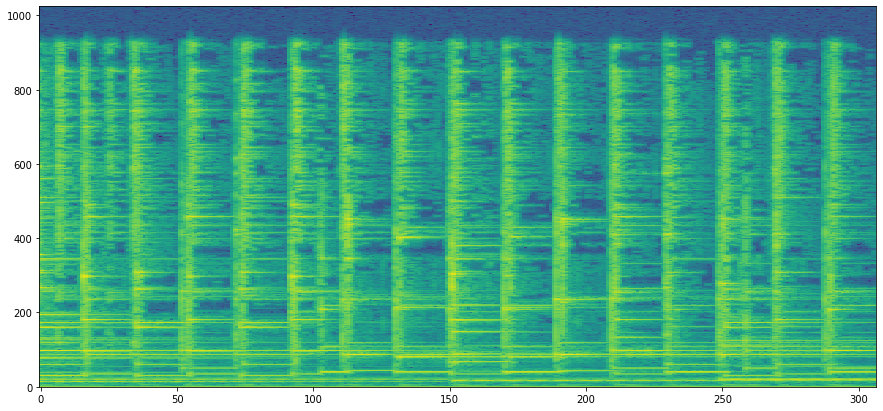

In [4]:
WINDOW_SIZE = 2048 #@param {type:"number"}
HOP_SIZE = 512 #@param {type:"number"}
WIN_TYPE = "hanning" #@param ["hanning", "blackman", "rectangular", "triangular"]

window = {'hanning':np.hanning,'blackman':np.blackman,'rectangular':np.ones,'triangular':np.bartlett}
spectrogram = stft(x,window[WIN_TYPE](WINDOW_SIZE),WINDOW_SIZE,HOP_SIZE)
plt.figure(figsize=(15,7))
plt.imshow(10*np.log10(np.abs(spectrogram)+1e-10),aspect='auto',origin='bottom')

### Inversión de espectrogramas from scratch

A la hora de procesar señales de audio, es fundamental poder volver al dominio temporal. Con una elección adecuada de los parámetros de la STFT, es posible recuperar la señal en tiempo. La transformada discreta de Fourier inversa (IDFT) permite volver al dominio temporal cada ventana:

$x[n]=\frac{1}{N}\sum_{k=0}^{N-1} X[k]e^{\frac{j2\pi kn}{N}}$

Luego, las mismas (que estarán solapadas si el tamaño de salto es menor al de ventana), se suman en un proceso que se denomina Overlap and Add. Es importante al elegir las ventanas asegurarse de que cumplan el criterio Constant Overlap and Add, ya que si la suma de las ventanas elegidas solapadas no da una constante se producirá una distorsión de la señal original.

In [0]:
def istft(spec,win_size,hop_size):
  len_signal = (spec.shape[1])*hop_size+win_size
  recovered_signal = np.zeros((len_signal,))
  for win_idx,spectrum in enumerate(spec.T):
    #spectrum = np.concatenate([spectrum,np.flip(spectrum[1:-1])]) #Vuelvo a poner las frecuencias que quite por paridad del espectro
    windowed_signal = np.fft.irfft(spectrum) #Aplico la IFFT y obtengo entonces el cacho de señal enventanada
    recovered_signal[win_idx*hop_size:win_idx*hop_size + win_size] = recovered_signal[win_idx*hop_size:win_idx*hop_size + win_size] + windowed_signal
  
  return recovered_signal

In [6]:
recovered_audio = istft(spectrogram,WINDOW_SIZE,HOP_SIZE)
Audio(recovered_audio,rate = fs)

### Criterio Constant Overlap-Add (COLA)

Experimentar combinaciones de tipo, tamaño y salto de ventana. Verificar si se cumple el criterio COLA:

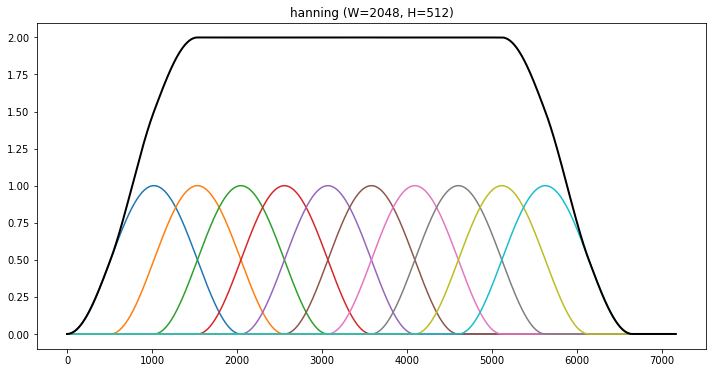

In [9]:
def check_cola(window,hop_size,title='',n_windows=10):
  win_length = window.shape[0]
  ola_result = np.zeros(hop_size*n_windows + win_length)
  plt.figure(figsize=(12,6))
  for i in range(n_windows):
    win_i = np.zeros(hop_size*n_windows + win_length)
    win_i[i*hop_size:i*hop_size+win_length] = window
    ola_result[i*hop_size:i*hop_size+win_length] = ola_result[i*hop_size:i*hop_size+win_length] + window
    plt.plot(win_i)
  plt.plot(ola_result,linewidth=2,color='k')
  plt.title(title)

WIN_SIZE = 2048 #@param {type:"number"}
HOP_SIZE = 512 #@param {type:"number"}
win_type = "hanning" #@param ["hanning", "blackman", "rectangular", "triangular"]

window = {'hanning':np.hanning,'blackman':np.blackman,'rectangular':np.ones,'triangular':np.bartlett}
check_cola(window[win_type](WIN_SIZE),HOP_SIZE,title='{} (W={}, H={})'.format(win_type,WIN_SIZE,HOP_SIZE))

# Separación de fuentes armónicas y percusivas (HPSS)

En esta sección implementaremos un sistema sencillo de separación de fuentes armónicas y percusivas (HPSS). El objetivo será implementar y entender el flujo de trabajo al procesar señales en el dominio tiempo-frecuencia.

Lo primero que haremos es calcular magnitud y fase del espectrograma que generamos previamente:

In [0]:
magnitude_spectrogram = np.abs(spectrogram)
phase_spectrogram = np.angle(spectrogram)

Nuestra señal ya se encuentra en el dominio tiempo-frecuencia. Ahora hay que implementar un algoritmo que sea capaz de obtener las componentes armónicas y percusivas a partir del espectrograma.

Para esto explotaremos los siguientes patrones que se manifiestan en eventos armónicos y percusivos:

* Las componentes percusivas son de corta duración y poseen energía en gran parte del espectro.
* Las componentes armónicas permanecen más en el tiempo y poseen energía en regiones específicas del espectro (fundamental y armónicos)

Si pensamos al espectrograma como una imagen, las componentes armónicas se verán como líneas horizontales, mientras que las percusivas como líneas verticales.

Explotando estas características, podemos aplicar un procesamiento al espectrograma que permita realzar las líneas verticales y las horizontales. Una opción es usar filtros de mediana movil en el eje del tiempo y el de frecuencias.

In [0]:
#Filtros de mediana movil

#def median_filter(vector,L,S):
#  start_idxs = np.arange(0,vector.shape[0]-L,S)
#  filtered_vector = []
#  for idx in start_idxs:
#    vector_window = vector[idx:idx+L]
#    window_median = np.median(vector_window)
#    filtered_vector.append(window_median)

#  return np.array(filtered_vector)

#Implementación más rápida:

def median_filter(array,L,S):
    nrows = ((array.size-L)//S+1)
    n = array.strides[0]
    strided = np.lib.stride_tricks.as_strided(array, shape = (nrows,L), strides = (S*n,n))
    medianfiltered = np.median(strided,axis=1)
    return medianfiltered

Si aplicamos un filtro de mediana movil en el eje de frecuencias, cuando la ventana esté sobre una componente percusiva, la mayoría de los elementos poseeran energía, siendo el valor resultante elevado, mientras que si se está sobre una componente armónica, pocos elementos estarán activos y el valor resultante será bajo. Por ende, se obtendrá un espectrograma con sus líneas verticales (correspondientes a las componentes percusivas) enfatizadas. 

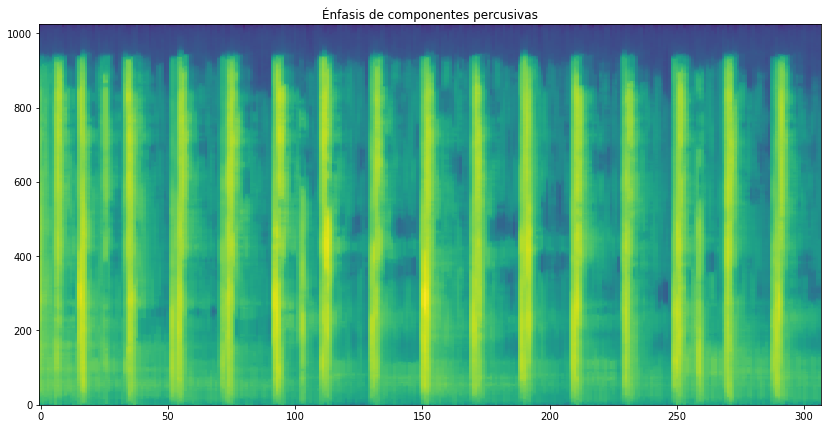

In [12]:
PERC_MEDIAN_WINSIZE = 80
def percussive_emphasis(magnitude_spectrogram,win_size):
  percussive = []
  n_pad = (win_size-1)//2
  padded_spectrogram = np.concatenate((np.zeros((win_size - 1 - n_pad,magnitude_spectrogram.shape[1])),magnitude_spectrogram,np.zeros((n_pad,magnitude_spectrogram.shape[1]))))
  for col in padded_spectrogram.T:
    percussive.append(median_filter(col,win_size,1))
  return np.array(percussive).T

percussive_emphasized = percussive_emphasis(magnitude_spectrogram,PERC_MEDIAN_WINSIZE)
plt.figure(figsize=(14,7))
plt.title('Énfasis de componentes percusivas')
plt.imshow(10*np.log10(np.abs(percussive_emphasized)+1e-6),aspect='auto',origin='bottom')

Por otro lado, si aplicamos un filtro de mediana movil en el eje del tiempo, cuando la ventana esté sobre una componente armónica, la mayoría de los elementos poseeran energía, siendo el valor resultante elevado, mientras que si se está sobre una componente percusiva, pocos elementos estarán activos y el valor resultante será bajo. Por ende, se obtendrá un espectrograma con sus líneas horizontales (correspondientes a las componentes armónicas) enfatizadas. 

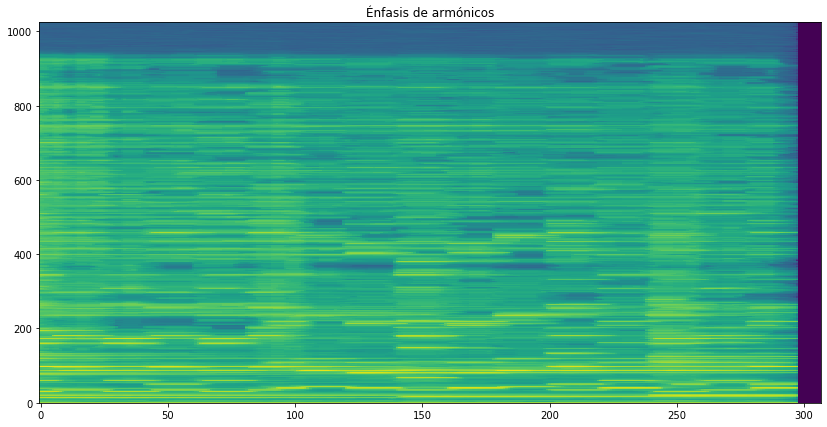

In [14]:
HARM_MEDIAN_WINSIZE = 20
def harmonic_emphasis(magnitude_spectrogram,win_size):
  harmonic = []
  padded_spectrogram = np.concatenate((magnitude_spectrogram,np.zeros((magnitude_spectrogram.shape[0],win_size-1))),axis=1)
  for col in padded_spectrogram:
    harmonic.append(median_filter(col,win_size,1))
  return np.array(harmonic)

harmonic_emphasized = harmonic_emphasis(magnitude_spectrogram,HARM_MEDIAN_WINSIZE)
plt.figure(figsize=(14,7))
plt.title('Énfasis de armónicos')
plt.imshow(10*np.log10(np.abs(harmonic_emphasized)+1e-6),aspect='auto',origin='bottom')

In [15]:
harmonic_audio = istft(harmonic_emphasized*np.exp(1j*phase_spectrogram),WINDOW_SIZE,HOP_SIZE)
print('Componentes armónicas:')
display(Audio(harmonic_audio,rate=fs))

percussive_audio = istft(percussive_emphasized*np.exp(1j*phase_spectrogram),WINDOW_SIZE,HOP_SIZE)
print('Componentes percusivas:')
display(Audio(percussive_audio,rate=fs))

Componentes armónicas:


Componentes percusivas:


Idealmente, cuando separamos fuentes queremos obtener la señal original al sumarlas...

In [16]:
recovered_audio = percussive_audio + harmonic_audio
Audio(recovered_audio[:len(x)] - x, rate = fs)

### Filtrado en Tiempo-Frecuencia

Para separar las componentes armónicas y percusivas, o en general fuentes, podemos armar un filtro en el dominio tiempo-frecuencia que simplemente atenúe las partes del espectro que no deseamos y preserve las que si. Una forma sencilla de calcular este filtro es fijandose para cada elemento del espectrograma si la fuente que deseo separar posee más energía que las demás fuentes. Si la fuente predomina, el filtro toma valor 1 y por ende conserva el elemento, por el contrario si no predomina el filtro toma valor 0 y el elemento se elimina. Esto resulta en la generación de una máscara binaria:

$M_i[n,k]=
\begin{cases}
\text{$1 \quad si \quad S_i \geq S_j \quad \forall i \neq j$ } \\
\text{$0 \quad$en otro caso}
\end{cases}
$

In [0]:
def binary_mask(sources):
  sources = np.stack(sources)
  binary_mask = (np.max(sources,axis=0)==sources)
 
  return binary_mask

Text(0.5, 1.0, 'Componentes percusivas')

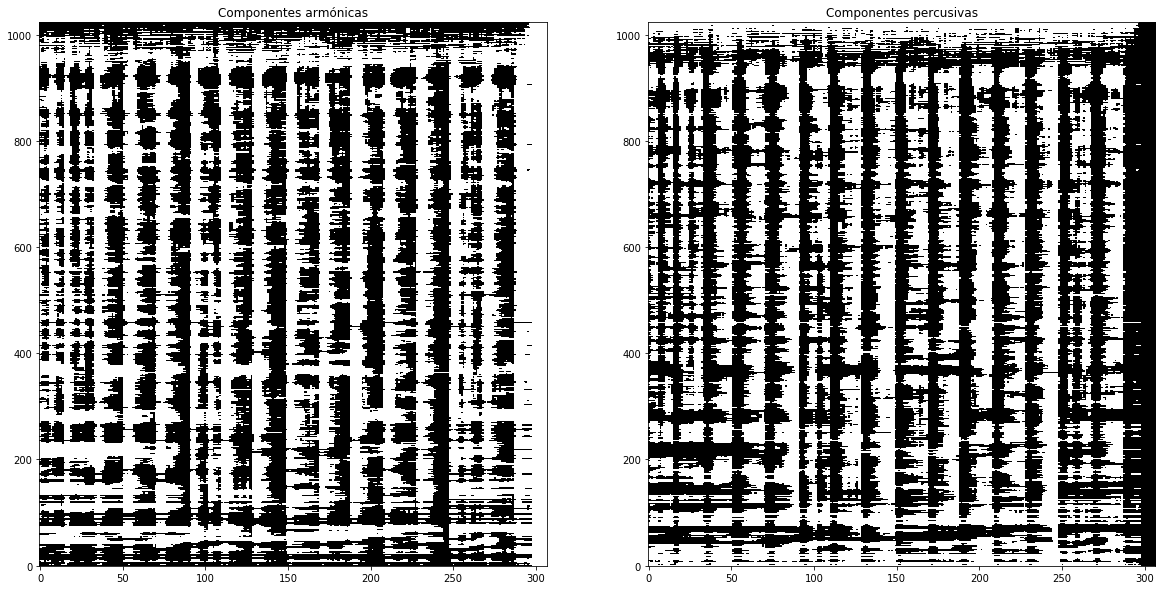

In [18]:
#@title Máscaras binarias
b_masks = binary_mask([harmonic_emphasized,percussive_emphasized])
h_mask = b_masks[0]
p_mask = b_masks[1]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(h_mask,cmap='binary',aspect='auto',origin='bottom')
ax[0].set_title('Componentes armónicas')
ax[1].imshow(p_mask,cmap='binary',aspect='auto',origin='bottom')
ax[1].set_title('Componentes percusivas')

Una vez calculadas las máscaras, el filtrado se realiza multiplicando elemento a elemento el espectrograma del audio original y la máscara. Finalmente se aplica la ISTFT para volver al dominio temporal.

In [19]:
percussive_spectrogram = p_mask*spectrogram
percussive_audio = istft(percussive_spectrogram,WINDOW_SIZE,HOP_SIZE)
print('Componentes percusivas')
display(Audio(percussive_audio,rate=fs))

harmonic_spectrogram = h_mask*spectrogram
harmonic_audio = istft(harmonic_spectrogram,WINDOW_SIZE,HOP_SIZE)
print('Componentes armónicas')
display(Audio(harmonic_audio,rate=fs))

Componentes percusivas


Componentes armónicas


In [21]:
#@title Hora de experimentar
def hpss(path,psize=17,hsize=17,window_size=2048,hop_size=512,window=None,init_audio=None,end_audio=None):
  if window is None:
    window = np.hanning(window_size)

  x, fs = librosa.core.load(path,sr=None)

  if init_audio is None:
    init_audio = 0
  else:
    init_audio = int(init_audio*fs)
  if end_audio is None:
    end_audio = x.shape[0]
  else:
    end_audio = int(end_audio*fs)

  x = x[init_audio:end_audio]

  spectrogram = stft(x,window,window_size,hop_size)
  magnitude_spectrogram = np.abs(spectrogram)
  phase_spectrogram = np.angle(spectrogram)

  percussive_emphasized = percussive_emphasis(magnitude_spectrogram,psize)
  harmonic_emphasized = harmonic_emphasis(magnitude_spectrogram,hsize)

  mask = binary_mask([harmonic_emphasized,percussive_emphasized])
  percussive_spectrogram = mask[1]*spectrogram
  percussive_audio = istft(percussive_spectrogram,window_size,hop_size)

  harmonic_spectrogram = mask[0]*spectrogram
  harmonic_audio = istft(harmonic_spectrogram,window_size,hop_size)

  return harmonic_audio, percussive_audio, fs

def librosa_hpss(path,ksize=17,window_size=2048,hop_size=512,window = None,init_audio=None,end_audio=None):
  if window is None:
    window = np.hanning(window_size)

  x, fs = librosa.core.load(path,sr=None)

  if init_audio is None:
    init_audio = 0
  else:
    init_audio = int(init_audio*fs)
  if end_audio is None:
    end_audio = x.shape[0]
  else:
    end_audio = int(end_audio*fs)

  x = x[init_audio:end_audio]

  spectrogram = librosa.stft(x,win_length = window_size,hop_length=hop_size,window=window)
  h_spec, p_spec = librosa.decompose.hpss(spectrogram,kernel_size = ksize)
  h = librosa.istft(h_spec,hop_length=hop_size,win_length=window_size,window=window)
  p = librosa.istft(p_spec,hop_length=hop_size,win_length=window_size,window=window)

  return h,p,fs

#@markdown ¿Qué efecto tiene el tamaño del filtro? ¿Cómo interactúa con el tamaño de ventana y salto? ¿Qué se escucha si no se cumple el criterio COLA? ¿Qué instrumentos musicales tenderán a ser separados si aplico HPSS en una canción de rock?

PATH = "gamelan.mp3" #@param {type:"string"}
WIN_SIZE = 2048 #@param {type:"number"}
HOP_SIZE = 512 #@param {type:"number"}
kernel_size = 9 #@param {type:"slider", min:5, max: 50}

win_type = "hanning" #@param ["hanning", "blackman", "rectangular", "triangular"]
init_audio = 0 #@param {type:"number"}
end_audio = 5 #@param {type:"number"}
window = {'hanning':np.hanning,'blackman':np.blackman,'rectangular':np.ones,'triangular':np.bartlett} 

harm, perc, fs = librosa_hpss(PATH,kernel_size,WIN_SIZE,HOP_SIZE,window[win_type](WIN_SIZE),init_audio=init_audio,end_audio=end_audio)
print('Componentes armónicas')
display(Audio(harm,rate=fs))
print('Componentes percusivas')
display(Audio(perc,rate=fs))

Componentes armónicas


Componentes percusivas


### Otras máscaras TF

En el caso de que 2 fuentes se solapen en el espectrograma, habrían regiones del mismo que pertenecerían a ambas. Sin embargo, las máscaras binarias asignarían la región a una sola de las fuentes. Es necesario entonces construir máscaras más suaves, que permitan asignar una región del espectrograma a más de una fuente.

Una opción son las máscaras suaves:

$M_i[n,k]=\frac{S_i[n,k]}{\sum_{j=1}^{N}S_j[n,k]}$

en las que el valor de la máscara queda determinado por cuánto contribuye una fuente $S_i$ al valor de un elemento del espectrograma, relativo a la contribución de las $N$ fuentes presentes en la mezcla.

Pensar: ¿por qué las máscaras suaves introducen más interferencias pero reducen los artefactos comparado con máscaras binarias?

In [0]:
def soft_mask(sources):
  masks = []
  mix_sum = np.sum(np.array(sources),axis=0)
  for source in sources:
    masks.append(source/mix_sum)

  return masks

Text(0.5, 1.0, 'Máscara suave para componentes percusivas')

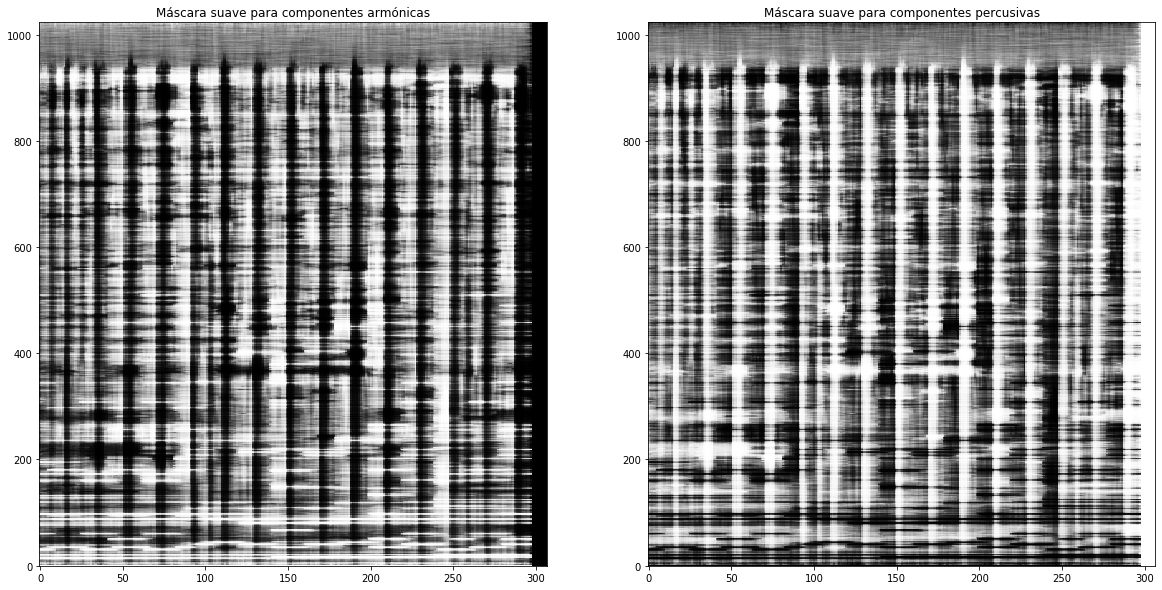

In [23]:
s_masks = soft_mask([harmonic_emphasized,percussive_emphasized])
h_mask = s_masks[0]
p_mask = s_masks[1]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(h_mask,cmap='gray',aspect='auto',origin='bottom')
ax[0].set_title('Máscara suave para componentes armónicas')
ax[1].imshow(p_mask,cmap='gray',aspect='auto',origin='bottom')
ax[1].set_title('Máscara suave para componentes percusivas')

In [24]:
percussive_spectrogram = p_mask*spectrogram
percussive_audio = istft(percussive_spectrogram,WINDOW_SIZE,HOP_SIZE)
print('Componentes percusivas')
display(Audio(percussive_audio,rate=fs))

harmonic_spectrogram = h_mask*spectrogram
harmonic_audio = istft(harmonic_spectrogram,WINDOW_SIZE,HOP_SIZE)
print('Componentes armónicas')
display(Audio(harmonic_audio,rate=fs))

Componentes percusivas


Componentes armónicas


### Hybrid masks

Otra opción es combinar ambas máscaras (binarias y suaves):

$M_{híbrida}[n,k]=\alpha M_{suave}[n,k] + (1-\alpha) M_{binaria}[n,k]$



In [0]:
def hybrid_mask(sources,alpha):
  softmask = np.array(soft_mask(sources))
  binarymask = np.array(binary_mask(sources))

  hybridmask = alpha*softmask + (1-alpha)*binarymask

  return list(hybridmask)

Text(0.5, 1.0, 'Máscara híbrida (alpha =0.5) para componentes percusivas')

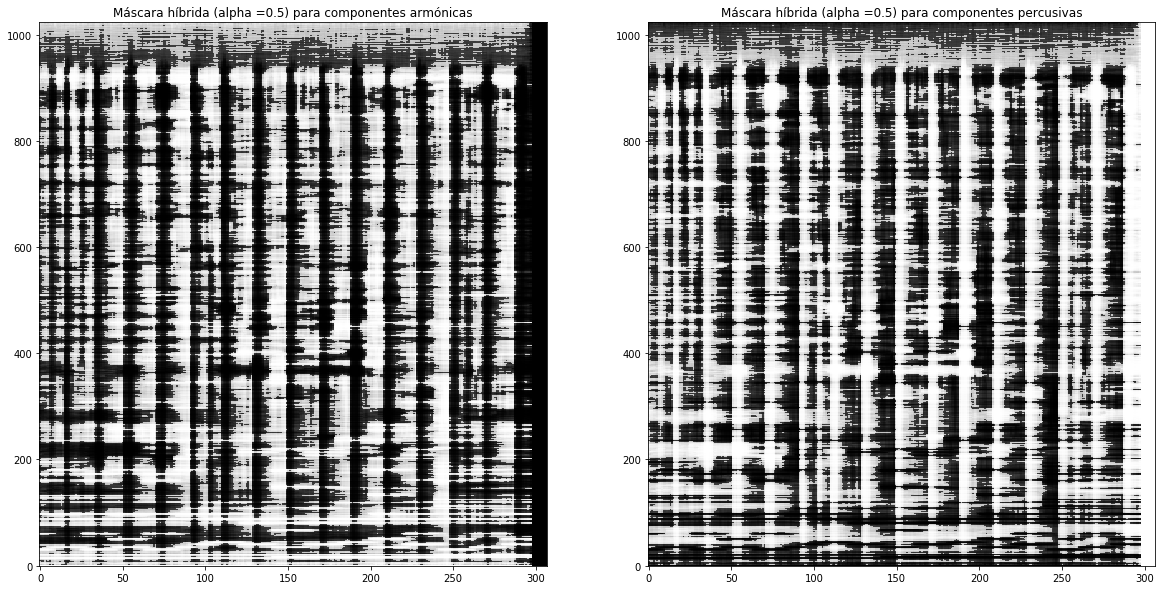

In [26]:
hybridmask = hybrid_mask([harmonic_emphasized,percussive_emphasized],0.5)
h_mask = hybridmask[0]
p_mask = hybridmask[1]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(h_mask,cmap='gray',aspect='auto',origin='bottom')
ax[0].set_title('Máscara híbrida (alpha =0.5) para componentes armónicas')
ax[1].imshow(p_mask,cmap='gray',aspect='auto',origin='bottom')
ax[1].set_title('Máscara híbrida (alpha =0.5) para componentes percusivas')

In [27]:
percussive_spectrogram = p_mask*spectrogram
percussive_audio = istft(percussive_spectrogram,WINDOW_SIZE,HOP_SIZE)
print('Componentes percusivas')
display(Audio(percussive_audio,rate=fs))

harmonic_spectrogram = h_mask*spectrogram
harmonic_audio = istft(harmonic_spectrogram,WINDOW_SIZE,HOP_SIZE)
print('Componentes armónicas')
display(Audio(harmonic_audio,rate=fs))

Componentes percusivas


Componentes armónicas


# Substracción espectral

Habla relativamente limpio:

In [28]:
clean_speech,fs = librosa.core.load('soroche.mp3')

clean_speech = clean_speech[int(13.5*fs):18*fs]
Audio(clean_speech,rate=fs)

Ruido gaussiano:

In [29]:
noise = np.random.randn(clean_speech.shape[0])
Audio(noise,rate=fs)

In [30]:
def snr_sum(target,noise,snr):
  target_rms = 10*np.log10(np.mean(librosa.feature.rmse(target)))
  noise_rms = 10*np.log10(np.mean(librosa.feature.rmse(noise)))
  noise_target_rms = target_rms - snr
  alpha = (10**(noise_target_rms/10))/(10**(noise_rms/10))


  return target + alpha*noise
  
noisy_10 = snr_sum(clean_speech,noise,10)
print("SNR: 10 dB")
Audio(noisy_10,rate=fs)

SNR: 10 dB


Estimamos la señal de ruido utilizando los primeros segundos de audio en los cuales no hay voz. Esto es una solución rápida y poco robusta. Una mejor opción es utilizar un sistema de Voice Activity Detection (VAD) para estimar los momentos de silencio y de habla.

In [31]:
noise_estimate = noisy_10[:int(0.8*fs)]
Audio(noise_estimate,rate=fs)

Calculamos el espectrograma del ruido y promediamos el espectro de los múltiples frames adyacentes. De esta manera hacemos una estimación de la envolvente espectral del ruido

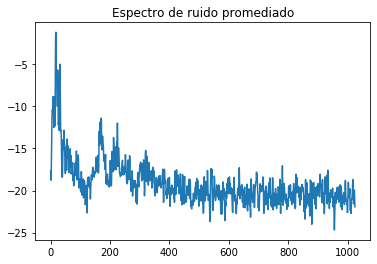

In [32]:
x_noise_stft = librosa.stft(noise_estimate,hop_length=512,win_length=2048)
mean_noise_spectrum = np.mean(np.abs(x_noise_stft),axis=1)
plt.title("Espectro de ruido promediado")
plt.plot(20*np.log10(mean_noise_spectrum))

Text(0.5, 1.0, 'Habla + Ruido')

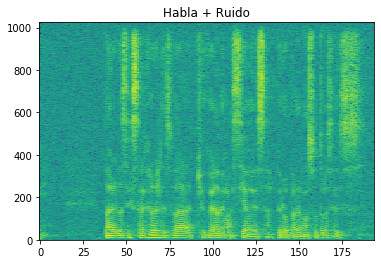

In [33]:
noisy_stft = librosa.stft(noisy_10,hop_length = 512,win_length = 2048)
plt.imshow(20*np.log10(np.abs(noisy_stft)),aspect='auto',origin='bottom',vmin=-80)
plt.title('Habla + Ruido')

Text(0.5, 1.0, 'Ruido estimado')

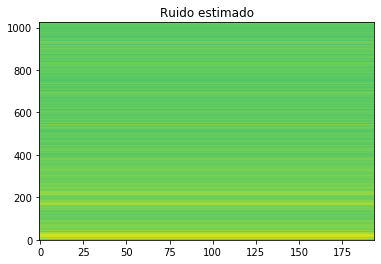

In [34]:
noise_estimate_stft = np.tile(np.expand_dims(mean_noise_spectrum,1),(1,noisy_stft.shape[1]))
plt.imshow(20*np.log10(noise_estimate_stft),aspect='auto',origin='bottom',vmin=-80)
plt.title('Ruido estimado')

Ahora simplemente le restamos al espectrograma de la señal el espectrograma del ruido que estimamos. Tenemos que tener en cuenta que podrían surgir valores negativos los cuales no tienen sentido en la magnitud de un espectrograma, por ende hay que volverlos cero.

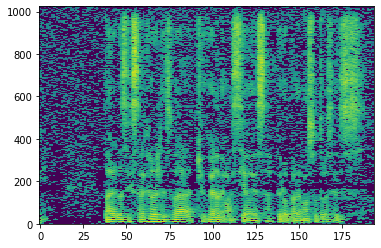

In [35]:
x_spectral_sub_magnitude = np.abs(noisy_stft) - noise_estimate_stft
x_spectral_sub_magnitude[x_spectral_sub_magnitude<1e-15] = 1e-15

plt.imshow(20*np.log10(np.abs(x_spectral_sub_magnitude)),aspect='auto',origin='bottom',vmin=-80)

Finalmente usamos la fase del espectrograma original y lo invertimos, obteniendo una señal más limpia.

In [36]:
x_speech_stft = x_spectral_sub_magnitude*np.exp(1j*np.angle(noisy_stft))
enhanced_speech = librosa.istft(x_speech_stft,hop_length=512,win_length=2048)
Audio(enhanced_speech,rate=fs)

Podemos probar contaminar la señal con distintas SNR. A su vez, podemos experimentar restando en vez de la magnitud de los espectrogramas, su potencia espectral (las magnitudes elevadas al cuadrado), o probar con otros exponentes.

In [41]:
#@title Hora de experimentar
#@markdown ¿Qué pasa si el SNR es muy bajo con la fase? ¿Cuál es el efecto del alpha?

def spectral_subtract(x,noise_estimate,alpha=1):
    
    x_stft = librosa.stft(x,hop_length = 512,win_length = 2048)
    noise_stft = librosa.stft(noise_estimate,hop_length = 512,win_length = 2048)
    x_mag = np.abs(x_stft)
    noise_mag = np.abs(x_mag)
    mean_noise_mag = np.mean(noise_mag,axis=1)
    noise_estimate_mag = np.tile(np.expand_dims(mean_noise_mag,1),(1,x_stft.shape[1]))
    
    clean_mag = (x_mag**alpha - noise_estimate_mag**alpha)
    clean_mag[clean_mag<1e-10] = 1e-10
    clean_mag = clean_mag**(1.0/alpha)
    
    clean_stft = clean_mag*np.exp(1j*np.angle(x_stft))
    
    return librosa.istft(clean_stft,hop_length=512,win_length=2048)


SNR = 5 #@param {type:"number"}
alpha = 0.7 #@param {type:"number"}
print("Noisy speech. SNR: {}".format(SNR))
display(Audio(snr_sum(clean_speech,noise,SNR),rate=fs))
print('Enhanced speech:')
display(Audio(spectral_subtract(snr_sum(clean_speech,noise,SNR),noise_estimate,alpha=alpha),rate=fs))

Noisy speech. SNR: 5


Enhanced speech:
